In [16]:
# import required libraries

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# load the configuration form config.yaml

import yaml

with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

ticker = config["params"]["ticker"]
start_date = config["params"]["start_date"]
end_date = config["params"]["end_date"]
short_window = config["params"]["short_window"]
long_window = config["params"]["long_window"]
transaction_cost = config["params"]["transaction_cost"]

In [18]:
# Fetch historical stock data
data = yf.download(ticker, start=start_date, end=end_date)
data.head(25)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2018-01-02,40.524349,43.064999,43.075001,42.314999,42.540001,102223600
2018-01-03,40.517284,43.057499,43.637501,42.990002,43.132500,118071600
2018-01-04,40.705502,43.257500,43.367500,43.020000,43.134998,89738400
2018-01-05,41.168922,43.750000,43.842499,43.262501,43.360001,94640000
2018-01-08,41.016018,43.587502,43.902500,43.482498,43.587502,82271200
2018-01-09,41.011303,43.582500,43.764999,43.352501,43.637501,86336000
2018-01-10,41.001896,43.572498,43.575001,43.250000,43.290001,95839600
2018-01-11,41.234806,43.820000,43.872501,43.622501,43.647499,74670800


In [19]:
# Setting short and long term moving average

data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

In [20]:
data["Short_MA"]

Date
2018-01-02           NaN
2018-01-03           NaN
2018-01-04           NaN
2018-01-05           NaN
2018-01-08     43.343500
                 ...    
2022-12-23    132.841998
2022-12-27    132.373999
2022-12-28    131.121999
2022-12-29    129.953999
2022-12-30    129.493999
Name: Short_MA, Length: 1259, dtype: float64

In [21]:
data["Long_MA"]

Date
2018-01-02           NaN
2018-01-03           NaN
2018-01-04           NaN
2018-01-05           NaN
2018-01-08           NaN
                 ...    
2022-12-23    139.988235
2022-12-27    138.912941
2022-12-28    137.632353
2022-12-29    136.631177
2022-12-30    135.867647
Name: Long_MA, Length: 1259, dtype: float64

In [22]:
# Generate buy/sell signals

data['Signal'] = 0
data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1  # Buy signal
data.loc[data['Short_MA'] <= data['Long_MA'], 'Signal'] = -1  # Sell signal

In [23]:
# Identify when trades occur
data['Trade'] = data['Signal'].diff().fillna(0).abs()

In [24]:
# Backtest the strategy

data['Daily_Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Signal'].shift(1) * data['Daily_Return']  # Lag signal by 1 day


In [25]:
# Deduct transaction costs

data['Strategy_Return_with_Costs'] = data['Strategy_Return'] - (data['Trade'] * transaction_cost)

In [26]:
# Cumulative returns

data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
data['Cumulative_Strategy_Return_with_Costs'] = (1 + data['Strategy_Return_with_Costs']).cumprod()

In [27]:
# Plot the results

plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

/var/folders/bl/c9xq73wj61b5k_gjtrh9b0zh0000gn/T/ipykernel_4046/1002890467.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)


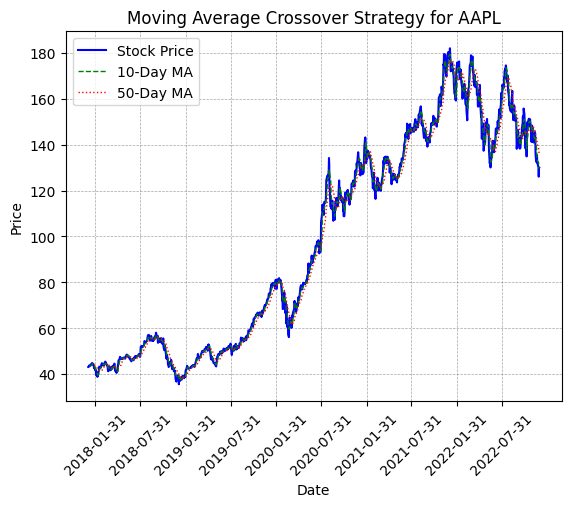

In [28]:
# Plot stock price and moving averages

plt.plot(data['Close'], label="Stock Price", color="blue", linewidth=1.5)
plt.plot(data['Short_MA'], label="10-Day MA", color="green", linestyle="--", linewidth=1)
plt.plot(data['Long_MA'], label="50-Day MA", color="red", linestyle=":", linewidth=1)

import pandas as pd

# Improve x-axis readability
plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6M"), rotation=45, fontsize=10)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Moving Average Crossover Strategy for AAPL")
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Legend inside the plot
plt.legend(loc="upper left", fontsize=10)
plt.legend()

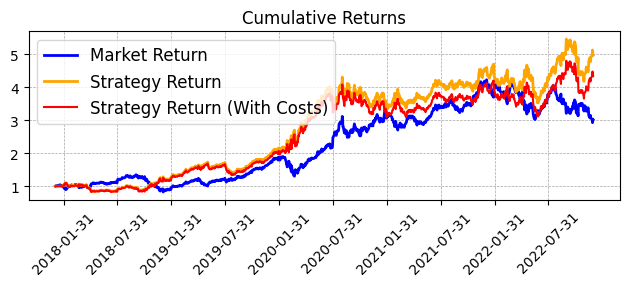

In [29]:
# Plot cumulative returns

plt.subplot(2, 1, 2)
plt.plot(data['Cumulative_Market_Return'], label="Market Return", color="blue", linewidth=2)
plt.plot(data['Cumulative_Strategy_Return'], label="Strategy Return", color="orange", linewidth=2)
plt.plot(data['Cumulative_Strategy_Return_with_Costs'], label="Strategy Return (With Costs)", color="red")

plt.title("Cumulative Returns")

# Improve x-axis readability with rotation and limited ticks
plt.xticks(pd.date_range(start=start_date, end=end_date, freq="6ME"), rotation=45, fontsize=10)

# Add gridlines for better visualization
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend position and format
plt.legend(loc="upper left", fontsize=12)

# Save the figure (optional) and show plot
plt.tight_layout()

plt.tight_layout()
plt.show()

In [30]:
# Strategy performance metrics
sharpe_ratio_with_costs = data['Strategy_Return_with_Costs'].mean() / data['Strategy_Return_with_Costs'].std() * (252**0.5)
print(f"Sharpe Ratio (With Costs): {sharpe_ratio_with_costs:.2f}")

Sharpe Ratio (With Costs): 1.05
